# Flatiron Health mCRC: Machine learning models with crude imputation 

**OBJECTIVE: Build 4 survival machine learning models using a crude imputation strategy. This imputation strategy assumes data is missing completely at random and will impute median for numerical variables and leave missing categorical entries as "unknown" (eg., possible ECOG values are 0, 1, 2, 3, 4, 5, and unknown). The machine learning model that performs best in this section will be used in the multiple imputation chained equation notebook.**

**BACKGROUND: The models were built using scikit-survival which is a machine learning library for survival analysis.  All 4 of these machine learning models are intended for survival analysis and so take into account censored data.** 

**The measure used to evaluate model performance is time-dependent area under the receiver operator curve (AUC) at 2 years. This metric determines how well a model can distinguish patients who die by time *t* from patients who die after this time. Our focus is to assess model discriminatory performance within the first couple years from metastatic diagnosis. Time dependent AUC was selected instead of the more frequently used metric in survival data, concordance index, since the concordance index is not time dependent and thus assess models performance over the entire range of survival times which in our case would be 8 years.** 

**The time point 2 year from metastatic diagnosis was selected as the primary time-point of interest and so all machine learning model hyperparamters are tuned to maximize performance at that time point. Secondary time points of interest include 1-year from metastatic diagnosis which will also be calculated for each model.**

**OUTLINE:**
1. **Preprocessing**
2. **Gradient boosting model** 
3. **Random survival forest** 
4. **Penalized Cox models**
5. **Linear support vector machine** 
6. **Calculating individual risk scores** 

## 1. Preprocessing 

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 

### 1.1 Importing full dataframes

In [2]:
# Import training set and set PatientID as index.
train = pd.read_csv('train_full.csv', index_col = 'PatientID')
print(len(train), train.index.is_unique)

27452 True


In [3]:
# Import test set and set PatientID as index.
test = pd.read_csv('test_full.csv', index_col = 'PatientID')
print(len(test), test.index.is_unique)

6863 True


### 1.2 Converting datatypes 

In [4]:
list(train.select_dtypes(include = ['object']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'crc_site',
 'KRAS',
 'dMMR_MSIh',
 'NRAS',
 'BRAF',
 'ecog_diagnosis']

In [5]:
to_be_categorical = list(train.select_dtypes(include = ['object']).columns)

In [6]:
to_be_categorical.append('met_year')

In [7]:
to_be_categorical.append('ses')

In [8]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    train[x] = train[x].astype('category')

In [9]:
list(train.select_dtypes(include = ['category']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'met_year',
 'crc_site',
 'KRAS',
 'dMMR_MSIh',
 'NRAS',
 'BRAF',
 'ecog_diagnosis',
 'ses']

In [10]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    test[x] = test[x].astype('category')

In [11]:
# Convert death_status into True or False (required for scikit-survival). 
train['death_status'] = train['death_status'].astype('bool')

In [12]:
# Convert death_status into True or False (required for scikit-survival).
test['death_status'] = test['death_status'].astype('bool')

### 1.3 Defining validation set

**A validation dataset will be constructed from the training set. This validation set will comprise of 25% of the training set. It will be used to assist in early stopping for the gradient boosting survival model and the random survival model. Like in the training-test split, a stratified approach will be carried out to preserve the distribution of diagnosis years.**   

In [13]:
train['met_year_cat'] = pd.cut(train['met_year'],
                               bins = [2012, 2014, 2016, 2018, 2020, 2022],
                               labels = ['13-14', '15-16', '17-18', '19-20', '21-22'])

In [14]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25, random_state = 42)

for sub_train_index, val_index in sss.split(train, train['met_year_cat']):
    sub_train = train.iloc[sub_train_index]
    val = train.iloc[val_index]

In [15]:
train = train.drop(columns = ['met_year_cat'])

In [16]:
sub_train = sub_train.drop(columns = ['met_year_cat'])

In [17]:
val = val.drop(columns = ['met_year_cat'])

In [18]:
pd.DataFrame(val.index, columns = ['PatientID']).to_csv('val_IDs.csv', index = False, header = True)

In [19]:
val_IDs = pd.read_csv('val_IDs.csv')

### 1.4 Separate into X and Y

In [20]:
# 'X' datasets
train_x = train.drop(columns = ['death_status', 'timerisk_activity']) #80% of data 

test_x = test.drop(columns = ['death_status', 'timerisk_activity']) #20% of data 

sub_train_x = sub_train.drop(columns = ['death_status', 'timerisk_activity']) #60% of data

val_x = val.drop(columns = ['death_status', 'timerisk_activity']) #20% of data 

In [21]:
# 'Y' datasets
# Death status and time until event needs to be stored as a structured array to be compatible with scikit-survival
y_dtypes = train[['death_status', 'timerisk_activity']].dtypes

train_y = np.array([tuple(x) for x in train[['death_status', 'timerisk_activity']].values], 
                   dtype = list(zip(y_dtypes.index, y_dtypes)))

test_y = np.array([tuple(x) for x in test[['death_status', 'timerisk_activity']].values], 
                  dtype = list(zip(y_dtypes.index, y_dtypes)))

sub_train_y = np.array([tuple(x) for x in sub_train[['death_status', 'timerisk_activity']].values],
                       dtype = list(zip(y_dtypes.index, y_dtypes)))

val_y = np.array([tuple(x) for x in val[['death_status', 'timerisk_activity']].values],
                 dtype = list(zip(y_dtypes.index, y_dtypes)))

### 1.5 Build pipeline

In [22]:
list(train_x.select_dtypes(exclude = ['category']).columns)

['age',
 'delta_met_diagnosis',
 'steroid_diag',
 'opioid_PO_diag',
 'nonopioid_PO_diag',
 'pain_IV_diag',
 'ac_diag',
 'antiinfective_IV_diag',
 'antiinfective_diag',
 'antihyperglycemic_diag',
 'ppi_diag',
 'antidepressant_diag',
 'bta_diag',
 'thyroid_diag',
 'is_diag',
 'adjuv',
 'medicare',
 'medicaid',
 'medicare_medicaid',
 'commercial',
 'patient_assistance',
 'other_govt',
 'self_pay',
 'other',
 'weight_diag',
 'bmi_diag',
 'bmi_diag_na',
 'weight_pct_change',
 'weight_pct_na',
 'weight_slope',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'cea_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'albumin_diag_na',
 'alp_diag_na',
 'alt_diag_na',
 'ast_diag_na',
 'bicarb_diag_na',
 'bun_diag_na',
 'calcium_diag_na',
 'cea_diag_na',
 'chloride_diag_na',
 'creatinine_diag_na',
 'hemoglobin_diag

In [23]:
# List of numeric variables, excluding binary variables. 
numerical_features = [
    'age',
    'delta_met_diagnosis',
    'weight_diag',
    'bmi_diag',
    'weight_pct_change',
    'weight_slope',
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'cea_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag', 
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'cea_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'alp_max',
    'alt_max',
    'ast_max',
    'bicarb_max',
    'bun_max',
    'calcium_max',
    'cea_max',
    'chloride_max',
    'creatinine_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'sodium_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'alp_min',
    'alt_min',
    'ast_min',
    'bicarb_min',
    'bun_min',
    'calcium_min',
    'cea_min',
    'chloride_min',
    'creatinine_min',
    'hemoglobin_min',
    'neutrophil_count_min',
    'platelet_min',
    'potassium_min',
    'sodium_min',
    'total_bilirubin_min',
    'wbc_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'cea_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'cea_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'icd_count']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [24]:
list(train_x.select_dtypes(include = ['category']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'met_year',
 'crc_site',
 'KRAS',
 'dMMR_MSIh',
 'NRAS',
 'BRAF',
 'ecog_diagnosis',
 'ses']

In [25]:
# List of categorical features.
categorical_features = list(train_x.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [26]:
# Remaining unprocessed columns which are binary variables
len(train_x.columns) - (len(numerical_features) + len(categorical_features))

98

In [27]:
all_columns = list(train_x.columns)

In [28]:
# Prints number of columns after removing columns that are numerical or categorical. 
for i in list(numerical_features + categorical_features):
    all_columns.remove(i)
len(all_columns)

98

In [29]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

## 2. Gradient boosting survival model

In [30]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, HalvingGridSearchCV
from sklearn.pipeline import make_pipeline

from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

from joblib import dump, load 

import matplotlib.pyplot as plt

import warnings 

**The gradient boosting survival model will be configured by setting a low learning rate (eg., <= 0.1) and choosing the number of trees by monitoring the 1 year AUC on the valdiation dataset and stopping once performance on the validation dataset begins to degrade. The learning rate will be tuned to achieve a target tree size >500. Once learning rate and tree number are set, a halving grid search with 3-fold cross validation will be performed to identify ideal max depth and subsample percentage.**  

### 2.1 Determining number of trees for full model 

**The full model includes all variables, notably 96 summary labs values which have significant missingness (>40%).**

In [31]:
sub_train_xt = preprocessor.fit_transform(sub_train_x)
val_xt = preprocessor.transform(val_x)

gbm_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                           learning_rate = 0.05,
                                           max_depth = 3,
                                           subsample = 0.75,
                                           verbose = 1,
                                           random_state = 42)

gbm_exp.fit(sub_train_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       84529.3659          15.4382          132.41m
         2       84016.2741          14.6091          132.36m
         3       84133.1867          13.9457          133.95m
         4       84291.9900          12.9009          135.44m
         5       84373.8707          12.9486          134.87m
         6       84569.5026          11.3336          134.68m
         7       84329.2443          11.1885          134.30m
         8       84247.8342          12.3477          134.07m
         9       84116.7093          10.8553          133.89m
        10       84160.3518          11.2159          133.78m
        20       83965.6829           8.0335          132.10m
        30       83705.5340           4.8881          131.46m
        40       83523.6164           3.9064          130.65m
        50       83011.6139           3.0037          129.47m
        60       83000.1447           2.9943          128.43m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [32]:
gbm_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] 
                  for risk_score in gbm_exp.staged_predict(val_xt)]

In [33]:
gbm_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] 
                     for risk_score in gbm_exp.staged_predict(sub_train_xt)]

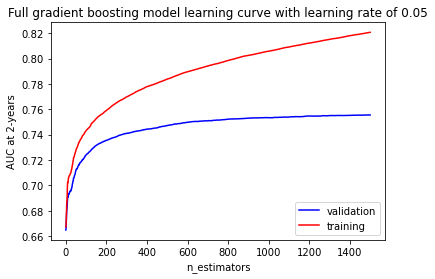

In [34]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm_staged_auc))
plt.plot(x, gbm_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Full gradient boosting model learning curve with learning rate of 0.05')

plt.show()

In [35]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm_staged_auc[x:x+24]))

In [36]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 975
Validation dataset AUC before degrading: 0.7534472234550058
Training dataset AUC before degrading: 0.8051298110538051


### 2.2 Determining number of trees for sparse model 

**The sparse model includes a subset of the summary lab values that are considered clinically relevant. Performance will be compared to the full model.**

In [37]:
all_labs = [
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'cea_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'albumin_diag_na',
    'alp_diag_na',
    'alt_diag_na',
    'ast_diag_na',
    'bicarb_diag_na',
    'bun_diag_na',
    'calcium_diag_na',
    'cea_diag_na',
    'chloride_diag_na',
    'creatinine_diag_na',
    'hemoglobin_diag_na',
    'neutrophil_count_diag_na',
    'platelet_diag_na',
    'potassium_diag_na',
    'sodium_diag_na',
    'total_bilirubin_diag_na',
    'wbc_diag_na',
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'cea_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'alp_max',
    'alt_max',
    'ast_max',
    'bicarb_max',
    'bun_max',
    'calcium_max',
    'cea_max',
    'chloride_max',
    'creatinine_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'sodium_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'alp_min',
    'alt_min',
    'ast_min',
    'bicarb_min',
    'bun_min',
    'calcium_min',
    'cea_min',
    'chloride_min',
    'creatinine_min',
    'hemoglobin_min',
    'neutrophil_count_min',
    'platelet_min',
    'potassium_min',
    'sodium_min',
    'total_bilirubin_min',
    'wbc_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'cea_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'cea_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'albumin_slope_na',
    'alp_slope_na',
    'alt_slope_na',
    'ast_slope_na',
    'bicarb_slope_na',
    'bun_slope_na',
    'calcium_slope_na',
    'cea_slope_na',
    'chloride_slope_na',
    'creatinine_slope_na',
    'hemoglobin_slope_na',
    'neutrophil_count_slope_na',
    'platelet_slope_na',
    'potassium_slope_na',
    'sodium_slope_na',
    'total_bilirubin_slope_na',
    'wbc_slope_na']

In [38]:
keep_labs = [
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'cea_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'albumin_diag_na',
    'alp_diag_na',
    'alt_diag_na',
    'ast_diag_na',
    'bicarb_diag_na',
    'bun_diag_na',
    'calcium_diag_na',
    'cea_diag_na',
    'chloride_diag_na',
    'creatinine_diag_na',
    'hemoglobin_diag_na',
    'neutrophil_count_diag_na',
    'platelet_diag_na',
    'potassium_diag_na',
    'sodium_diag_na',
    'total_bilirubin_diag_na',
    'wbc_diag_na',
    'alp_max',
    'alt_max',
    'ast_max',
    'cea_max',
    'creatinine_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'bicarb_min',
    'hemoglobin_min',
    'platelet_min',
    'sodium_min',
    'wbc_min']

In [39]:
drop_labs = [
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'cea_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'bicarb_max',
    'bun_max',
    'calcium_max',
    'chloride_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'sodium_max',
    'alp_min',
    'alt_min',
    'ast_min',
    'bun_min',
    'calcium_min',
    'cea_min',
    'chloride_min',
    'creatinine_min',
    'neutrophil_count_min',
    'potassium_min',
    'total_bilirubin_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'cea_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'cea_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'albumin_slope_na',
    'alp_slope_na',
    'alt_slope_na',
    'ast_slope_na',
    'bicarb_slope_na',
    'bun_slope_na',
    'calcium_slope_na',
    'cea_slope_na',
    'chloride_slope_na',
    'creatinine_slope_na',
    'hemoglobin_slope_na',
    'neutrophil_count_slope_na',
    'platelet_slope_na',
    'potassium_slope_na',
    'sodium_slope_na',
    'total_bilirubin_slope_na',
    'wbc_slope_na']

In [40]:
len(keep_labs) + len(drop_labs) == len(all_labs)

True

In [41]:
sub_train_x_red = sub_train_x.drop(columns = drop_labs)
val_x_red = val_x.drop(columns = drop_labs)

In [42]:
print(sub_train_x.shape)
print(sub_train_x_red.shape)
print(val_x.shape)
print(val_x_red.shape)

(20589, 221)
(20589, 132)
(6863, 221)
(6863, 132)


In [43]:
sub_train_x_red.loc[:, 'alp_max_na'] = np.where(sub_train_x_red['alp_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'alt_max_na'] = np.where(sub_train_x_red['alt_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'ast_max_na'] = np.where(sub_train_x_red['ast_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'cea_max_na'] = np.where(sub_train_x_red['cea_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'creatinine_max_na'] = np.where(sub_train_x_red['creatinine_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'total_bilirubin_max_na'] = np.where(sub_train_x_red['total_bilirubin_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'wbc_max_na'] = np.where(sub_train_x_red['wbc_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'albumin_min_na'] = np.where(sub_train_x_red['albumin_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'bicarb_min_na'] = np.where(sub_train_x_red['bicarb_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'hemoglobin_min_na'] = np.where(sub_train_x_red['hemoglobin_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'platelet_min_na'] = np.where(sub_train_x_red['platelet_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'sodium_min_na'] = np.where(sub_train_x_red['sodium_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'wbc_min_na'] = np.where(sub_train_x_red['wbc_min'].isna(), 1, 0)

In [44]:
val_x_red.loc[:, 'alp_max_na'] = np.where(val_x_red['alp_max'].isna(), 1, 0)
val_x_red.loc[:, 'alt_max_na'] = np.where(val_x_red['alt_max'].isna(), 1, 0)
val_x_red.loc[:, 'ast_max_na'] = np.where(val_x_red['ast_max'].isna(), 1, 0)
val_x_red.loc[:, 'cea_max_na'] = np.where(val_x_red['cea_max'].isna(), 1, 0)
val_x_red.loc[:, 'creatinine_max_na'] = np.where(val_x_red['creatinine_max'].isna(), 1, 0)
val_x_red.loc[:, 'total_bilirubin_max_na'] = np.where(val_x_red['total_bilirubin_max'].isna(), 1, 0)
val_x_red.loc[:, 'wbc_max_na'] = np.where(val_x_red['wbc_max'].isna(), 1, 0)
val_x_red.loc[:, 'albumin_min_na'] = np.where(val_x_red['albumin_min'].isna(), 1, 0)
val_x_red.loc[:, 'bicarb_min_na'] = np.where(val_x_red['bicarb_min'].isna(), 1, 0)
val_x_red.loc[:, 'hemoglobin_min_na'] = np.where(val_x_red['hemoglobin_min'].isna(), 1, 0)
val_x_red.loc[:, 'platelet_min_na'] = np.where(val_x_red['platelet_min'].isna(), 1, 0)
val_x_red.loc[:, 'sodium_min_na'] = np.where(val_x_red['sodium_min'].isna(), 1, 0)
val_x_red.loc[:, 'wbc_min_na'] = np.where(val_x_red['wbc_min'].isna(), 1, 0)

In [45]:
# List of numeric variables, excluding binary variables. 
numerical_features_red = [
    'age',
    'delta_met_diagnosis',
    'weight_diag',
    'bmi_diag',
    'weight_pct_change',
    'weight_slope',
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'cea_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'alp_max',
    'alt_max',
    'ast_max',
    'cea_max',
    'creatinine_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'bicarb_min',
    'hemoglobin_min',
    'platelet_min',
    'sodium_min',
    'wbc_min',
    'icd_count']

# Transformer will impute column medians and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [46]:
preprocessor_red = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features_red),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [47]:
print(sub_train_x_red.shape)
print(sub_train_y.shape)
print(val_x_red.shape)
print(val_y.shape)

(20589, 145)
(20589,)
(6863, 145)
(6863,)


In [48]:
sub_train_xt_red = preprocessor_red.fit_transform(sub_train_x_red)
val_xt_red = preprocessor_red.transform(val_x_red)

gbm_exp2 = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                           learning_rate = 0.05,
                                           max_depth = 3,
                                           subsample = 0.75,
                                           verbose = 1,
                                           random_state = 42)

gbm_exp2.fit(sub_train_xt_red, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       84529.4393          15.4646          129.58m
         2       84016.3610          14.6283          129.70m
         3       84133.4956          14.0001          130.03m
         4       84292.2341          12.8811          130.23m
         5       84370.9267          13.0463          130.73m
         6       84568.0617          11.2994          130.81m
         7       84326.9335          11.4357          130.84m
         8       84247.0321          11.8914          130.77m
         9       84114.6359          10.9153          130.76m
        10       84159.6151          11.0497          130.73m
        20       83969.3383           8.0121          130.08m
        30       83713.4536           5.0310          128.49m
        40       83526.4321           3.5761          127.27m
        50       83019.6035           3.0704          126.22m
        60       83007.7535           2.9063          125.22m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [49]:
gbm2_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_exp2.staged_predict(val_xt_red)]

In [50]:
gbm2_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_exp2.staged_predict(sub_train_xt_red)]

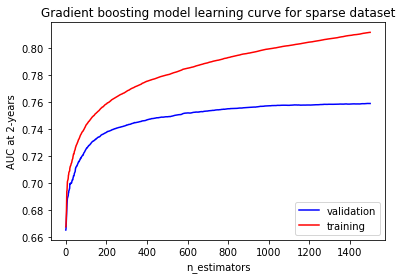

In [51]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm2_staged_auc))
plt.plot(x, gbm2_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm2_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for sparse dataset')

plt.show()

In [52]:
# Average AUC for every 25 additional trees. 
mean2_auc_list = []
for x in np.arange(0, len(gbm2_staged_auc), 25):
    mean2_auc_list.append(np.mean(gbm2_staged_auc[x:x+24]))

In [53]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean2_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm2_staged_auc[np.where(np.diff(mean2_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm2_staged_auc_tr[np.where(np.diff(mean2_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 1125
Validation dataset AUC before degrading: 0.7576826270493867
Training dataset AUC before degrading: 0.8023159104765142


**Performance of the sparse model appears about equivalent to the full model in regards to discriminatory performance on the validation set. The advantages of using the sparse model include less risk of overfitting of training set, faster computational speed, and improved interpretability of feature importance. In addition, there might be improved imputations of missing values with MICE. For these reasons, we'll plan to proceed with the sparse model.**

### 2.3 Further tuning of tree hyperparameters

**Tree depth and subsample will be tuned using a halving grid search with 3-fold cross validation. The other main tree hyperparameter is the minimum sample size in a terminal node (ie., leaf), but since we're using short trees it's unlikely to have significant impact on performance and so we'll omit from the parameter search to save computing time.** 

**Performing a traditional cartesian grid search for gradient boosting model tree hyperparameters is computationally challengng. A halving grid search approach is selected instead since it is much faster. The major drawback of the halving grid search is that good configurations that are slow to converge at the beginning will be pruned prematurely so you can’t be entirely ensure that you’ve identified the best hyperparameters.**  

**As you can see below, our parameter search space is very small. This is because even with a halving grid search it takes considerable time to build models on this dataset.** 

In [54]:
train_x_red = train_x.drop(columns = drop_labs)

In [55]:
train_x_red.loc[:, 'alp_max_na'] = np.where(train_x_red['alp_max'].isna(), 1, 0)
train_x_red.loc[:, 'alt_max_na'] = np.where(train_x_red['alt_max'].isna(), 1, 0)
train_x_red.loc[:, 'ast_max_na'] = np.where(train_x_red['ast_max'].isna(), 1, 0)
train_x_red.loc[:, 'cea_max_na'] = np.where(train_x_red['cea_max'].isna(), 1, 0)
train_x_red.loc[:, 'creatinine_max_na'] = np.where(train_x_red['creatinine_max'].isna(), 1, 0)
train_x_red.loc[:, 'total_bilirubin_max_na'] = np.where(train_x_red['total_bilirubin_max'].isna(), 1, 0)
train_x_red.loc[:, 'wbc_max_na'] = np.where(train_x_red['wbc_max'].isna(), 1, 0)
train_x_red.loc[:, 'albumin_min_na'] = np.where(train_x_red['albumin_min'].isna(), 1, 0)
train_x_red.loc[:, 'bicarb_min_na'] = np.where(train_x_red['bicarb_min'].isna(), 1, 0)
train_x_red.loc[:, 'hemoglobin_min_na'] = np.where(train_x_red['hemoglobin_min'].isna(), 1, 0)
train_x_red.loc[:, 'platelet_min_na'] = np.where(train_x_red['platelet_min'].isna(), 1, 0)
train_x_red.loc[:, 'sodium_min_na'] = np.where(train_x_red['sodium_min'].isna(), 1, 0)
train_x_red.loc[:, 'wbc_min_na'] = np.where(train_x_red['wbc_min'].isna(), 1, 0)

In [56]:
train_x_red.shape

(27452, 145)

In [57]:
# Find all pipe item unique keys 
pipe = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean2_auc_list) < 0)[0][0]*25,
                                                                        learning_rate = 0.05,
                                                                        random_state = 42))

estimator = as_cumulative_dynamic_auc_scorer(pipe, times = [730])

sorted(estimator.get_params().keys())

['estimator',
 'estimator__columntransformer',
 'estimator__columntransformer__cat',
 'estimator__columntransformer__cat__categories',
 'estimator__columntransformer__cat__drop',
 'estimator__columntransformer__cat__dtype',
 'estimator__columntransformer__cat__handle_unknown',
 'estimator__columntransformer__cat__sparse',
 'estimator__columntransformer__n_jobs',
 'estimator__columntransformer__num',
 'estimator__columntransformer__num__imputer',
 'estimator__columntransformer__num__imputer__add_indicator',
 'estimator__columntransformer__num__imputer__copy',
 'estimator__columntransformer__num__imputer__fill_value',
 'estimator__columntransformer__num__imputer__missing_values',
 'estimator__columntransformer__num__imputer__strategy',
 'estimator__columntransformer__num__imputer__verbose',
 'estimator__columntransformer__num__memory',
 'estimator__columntransformer__num__std_scaler',
 'estimator__columntransformer__num__std_scaler__copy',
 'estimator__columntransformer__num__std_scaler_

In [58]:
pipe = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean2_auc_list) < 0)[0][0]*25,
                                                                        learning_rate = 0.05,
                                                                        random_state = 42))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__gradientboostingsurvivalanalysis__max_depth': [2, 3, 4], 
              'estimator__gradientboostingsurvivalanalysis__subsample': [0.5, 0.75, 0.9]}

gbm_search = HalvingGridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid,
    cv = cv,
    factor = 2,
    resource = 'n_samples',
    refit = False,
    verbose = 1,
    random_state = 42,
    n_jobs = -1)

# Run search 
warnings.filterwarnings('ignore')
gbm_search.fit(train_x_red, train_y)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 3431
max_resources_: 27452
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 3431
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 5
n_resources: 6862
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 3
n_resources: 13724
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 27448
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                            transformers=[('num',
                                                                                                                           Pipeline(steps=[('imputer',
                                                                                                                                            SimpleImputer(strategy='median')),
                                                                                                                                           ('std_scaler',
                                                               

In [59]:
gbm_search.best_params_

{'estimator__gradientboostingsurvivalanalysis__max_depth': 4,
 'estimator__gradientboostingsurvivalanalysis__subsample': 0.5}

In [60]:
gbm_search_results = pd.DataFrame(gbm_search.cv_results_)

In [61]:
gbm_search_results.sort_values(by = 'rank_test_score').head(10)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__gradientboostingsurvivalanalysis__max_depth,param_estimator__gradientboostingsurvivalanalysis__subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
17,3,27448,5000.226835,10.045031,0.160814,0.001943,4,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.767397,0.768594,0.748983,0.761658,0.008976,1,0.836358,0.835757,0.841229,0.837781,0.002450
18,3,27448,4929.518936,3.253489,0.170539,0.002589,4,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.766761,0.768660,0.748014,0.761145,0.009317,2,0.836798,0.836876,0.843354,0.839009,0.003072
15,2,13724,1387.022055,2.738905,0.089217,0.001233,4,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.760971,0.766921,0.730243,0.752712,0.016072,3,0.870207,0.873979,0.877217,0.873801,0.002864
16,2,13724,1300.851691,125.262521,0.088550,0.002042,4,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.759993,0.765226,0.728857,0.751359,0.016054,4,0.870075,0.872817,0.877094,0.873329,0.002888
14,2,13724,1380.027871,0.332785,0.087718,0.005605,3,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.756175,0.764769,0.729003,0.749982,0.015244,5,0.827175,0.830346,0.836393,0.831305,0.003824
11,1,6862,294.834007,10.770464,0.058504,0.001308,4,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.770119,0.770302,0.709024,0.749815,0.028844,6,0.912505,0.911906,0.915312,0.913241,0.001485
13,1,6862,284.295662,1.209634,0.049192,0.001982,4,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.771983,0.767524,0.709122,0.749543,0.028640,7,0.914019,0.913758,0.917128,0.914968,0.001531
9,1,6862,298.531555,2.166152,0.049869,0.005150,3,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.769678,0.767633,0.709429,0.748913,0.027932,8,0.866730,0.864319,0.871049,0.867366,0.002784
10,1,6862,304.130933,1.689963,0.049910,0.002420,3,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.769800,0.767422,0.708586,0.748602,0.028313,9,0.867250,0.867515,0.874226,0.869664,0.003228
12,1,6862,309.625934,1.639674,0.047626,0.000842,4,0.9,{'estimator__gradientboostingsurvivalanalysis_...,0.774068,0.764349,0.704607,0.747675,0.030711,10,0.913240,0.911346,0.914375,0.912987,0.001249


### 2.4 Building and evaluating final model 

In [62]:
test_x_red = test_x.drop(columns = drop_labs)

In [63]:
test_x_red.loc[:, 'alp_max_na'] = np.where(test_x_red['alp_max'].isna(), 1, 0)
test_x_red.loc[:, 'alt_max_na'] = np.where(test_x_red['alt_max'].isna(), 1, 0)
test_x_red.loc[:, 'ast_max_na'] = np.where(test_x_red['ast_max'].isna(), 1, 0)
test_x_red.loc[:, 'cea_max_na'] = np.where(test_x_red['cea_max'].isna(), 1, 0)
test_x_red.loc[:, 'creatinine_max_na'] = np.where(test_x_red['creatinine_max'].isna(), 1, 0)
test_x_red.loc[:, 'total_bilirubin_max_na'] = np.where(test_x_red['total_bilirubin_max'].isna(), 1, 0)
test_x_red.loc[:, 'wbc_max_na'] = np.where(test_x_red['wbc_max'].isna(), 1, 0)
test_x_red.loc[:, 'albumin_min_na'] = np.where(test_x_red['albumin_min'].isna(), 1, 0)
test_x_red.loc[:, 'bicarb_min_na'] = np.where(test_x_red['bicarb_min'].isna(), 1, 0)
test_x_red.loc[:, 'hemoglobin_min_na'] = np.where(test_x_red['hemoglobin_min'].isna(), 1, 0)
test_x_red.loc[:, 'platelet_min_na'] = np.where(test_x_red['platelet_min'].isna(), 1, 0)
test_x_red.loc[:, 'sodium_min_na'] = np.where(test_x_red['sodium_min'].isna(), 1, 0)
test_x_red.loc[:, 'wbc_min_na'] = np.where(test_x_red['wbc_min'].isna(), 1, 0)

In [64]:
test_x_red.shape

(6863, 145)

In [65]:
gbm_crude = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 1125,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 4,
                                                                             subsample = 0.5,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_crude.fit(train_x_red, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       74056.2761          43.8887          177.26m
         2       72757.5908          43.7657          178.66m
         3       73466.6858          42.3391          179.30m
         4       74361.5066          39.3682          179.45m
         5       73415.4920          37.8086          179.28m
         6       73125.1606          37.1606          179.19m
         7       73763.0678          34.8367          179.05m
         8       73838.7930          33.6160          178.97m
         9       73400.6211          33.3161          178.80m
        10       73719.8568          30.3700          178.61m
        20       72702.6117          21.6312          176.30m
        30       72990.0851          16.8306          174.27m
        40       72689.4740          11.5939          172.45m
        50       72837.0959          10.8325          170.97m
        60       72132.7328           8.7195          169.47m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [66]:
gbm_risk_scores_te = gbm_crude.predict(test_x_red)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.7688096396149047


In [67]:
gbm_risk_scores_tr = gbm_crude.predict(train_x_red)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8202618486083906


In [68]:
# Bootstrap 10000 2 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [69]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.006324111218521225


In [70]:
# Bootstrap 10000 2-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [71]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.002853233889638351


In [72]:
crude_auc_data = {'model': ['gbm_crude'],
                  'auc_2yr_te': [gbm_auc_te],
                  'sem_te': [standard_error_te],
                  'auc_2yr_tr': [gbm_auc_tr],
                  'sem_tr': [standard_error_tr]}

crude_auc_df = pd.DataFrame(crude_auc_data)

In [73]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.76881,0.006324,0.820262,0.002853


In [74]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [75]:
times = np.arange(30, 1810, 30)
crude_gbm_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = crude_gbm_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_auc_over5 = pd.DataFrame(times_data, index = ['gbm_crude'])

In [76]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.856949,0.884151,0.866665,0.851224,0.844322,0.8383,0.830859,0.824993,0.820536,0.812844,...,0.742955,0.742386,0.740674,0.738619,0.737615,0.735382,0.736942,0.739815,0.737911,0.739676


In [77]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [78]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 195
Number of non-zero features in final model: 193


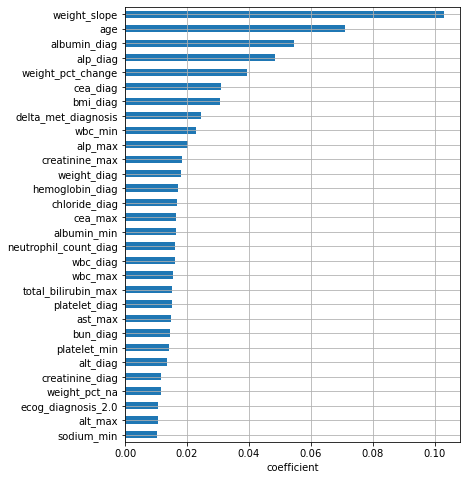

In [79]:
# Dataframe of coefficients for each variable 
coefficients_gbm = pd.DataFrame(
    gbm_crude.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_gbm.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_gbm.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

## 3 Random survival forest model

In [80]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, HalvingRandomSearchCV
from sklearn.pipeline import make_pipeline

from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

from sksurv.ensemble import RandomSurvivalForest

from joblib import dump, load 

import warnings 

**Similar to the gradient boosting survival model, the random survival model will first be configured by determining ideal number of trees using early stopping. Unlike the gradient boosting survival model, performance of the test set should not decrease with additional trees, so the main consideration is ensuring sufficiently high number of trees to achieve optimal test performance while minimzing computational time (ie., not building unnecessary number of trees). Once the ideal tree number is identified, a halving grid search with 3-fold cross validation will be performed to tune hyperparameters, though random forest models typically have excellent out-of-the-box performance so tuning will be cursory.**  

### 3.1 Number of trees 

In [81]:
# Create function that adds tree one at a time, calculates AUC at 1-yr on validation set, 
# and breaks once validation AUC decreases 5 times in a row

rsf = RandomSurvivalForest(min_samples_leaf = 10,
                           max_features = 0.333,
                           warm_start = True,
                           verbose = 0,
                           random_state = 42)

sub_train_xt_red = preprocessor_red.fit_transform(sub_train_x_red)
val_xt_red = preprocessor_red.transform(val_x_red)

max_yr_auc = 0
error_going_up = 0

for n_estimators in range(1, 1000): 
    rsf.n_estimators = n_estimators
    rsf.fit(sub_train_xt_red, sub_train_y)
    
    rsf_chf_funcs = rsf.predict_cumulative_hazard_function(val_xt_red)
    rsf_risk_scores = np.row_stack([chf(730) for chf in rsf_chf_funcs])
    rsf_yr_auc = cumulative_dynamic_auc(sub_train_y, val_y, rsf_risk_scores, 730)[0][0]
    
    if rsf_yr_auc > max_yr_auc:
        max_yr_auc = rsf_yr_auc
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

In [82]:
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(val_xt_red)
rsf_risk_scores = np.row_stack([chf(730) for chf in rsf_chf_funcs])
rsf_yr_auc = cumulative_dynamic_auc(sub_train_y, val_y, rsf_risk_scores, 730)[0][0]

print('Ideal number of trees:', rsf.n_estimators)
print('Validation set AUC at 2 years with ideal tree number:', round(rsf_yr_auc, 5))

Ideal number of trees: 47
Validation set AUC at 2 years with ideal tree number: 0.73498


### 3.2 Hyperparameter tuning 

**Seventy five trees will likely be enough to ensure optimal AUC performance. Next, we'll perform a grid search to tune hyperparameters. The hyperparamter with the largest impact on performance other than tree number is the number of features considered at any given split (ie., max_features). (Side note: if the number of features considered at each split includes all features (ie., max_features = 1) then the algrorithm will be equivalent to bagging decision trees.) Tree complexity, specifically number of samples in leaf nodes, will also be tuned in the grid search, though its impact on performance is likely marginal in comparison to number of trees or number of features considered at each split.** 

In [83]:
# Find all pipe item unique keys 
pipe = make_pipeline(preprocessor_red, RandomSurvivalForest(n_estimators = 75,
                                                            verbose = 0,
                                                            random_state = 42))

estimator = as_cumulative_dynamic_auc_scorer(pipe, times = [730])

sorted(estimator.get_params().keys())

['estimator',
 'estimator__columntransformer',
 'estimator__columntransformer__cat',
 'estimator__columntransformer__cat__categories',
 'estimator__columntransformer__cat__drop',
 'estimator__columntransformer__cat__dtype',
 'estimator__columntransformer__cat__handle_unknown',
 'estimator__columntransformer__cat__sparse',
 'estimator__columntransformer__n_jobs',
 'estimator__columntransformer__num',
 'estimator__columntransformer__num__imputer',
 'estimator__columntransformer__num__imputer__add_indicator',
 'estimator__columntransformer__num__imputer__copy',
 'estimator__columntransformer__num__imputer__fill_value',
 'estimator__columntransformer__num__imputer__missing_values',
 'estimator__columntransformer__num__imputer__strategy',
 'estimator__columntransformer__num__imputer__verbose',
 'estimator__columntransformer__num__memory',
 'estimator__columntransformer__num__std_scaler',
 'estimator__columntransformer__num__std_scaler__copy',
 'estimator__columntransformer__num__std_scaler_

In [84]:
pipe = make_pipeline(preprocessor_red, RandomSurvivalForest(n_estimators = 75,
                                                            verbose = 0,
                                                            random_state = 42))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__randomsurvivalforest__max_features': [0.01, 0.05, 0.1, 0.333], 
              'estimator__randomsurvivalforest__min_samples_leaf': [5, 10, 15]}

rsf_search = HalvingRandomSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_distributions = param_grid,
    cv = cv,
    factor = 2,
    resource = 'n_samples',
    min_resources = 2500,
    refit = False,
    verbose = 1,
    random_state = 42,
    n_jobs = -1)

# Run search 
warnings.filterwarnings('ignore')
rsf_search.fit(train_x_red, train_y)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 2500
max_resources_: 27452
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 10
n_resources: 2500
Fitting 3 folds for each of 10 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 5
n_resources: 5000
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 3
n_resources: 10000
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 20000
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingRandomSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                      estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                            ColumnTransformer(remainder='passthrough',
                                                                                                              transformers=[('num',
                                                                                                                             Pipeline(steps=[('imputer',
                                                                                                                                              SimpleImputer(strategy='median')),
                                                                                                                                             ('std_scaler',
                                                 

In [85]:
rsf_search.best_params_

{'estimator__randomsurvivalforest__min_samples_leaf': 10,
 'estimator__randomsurvivalforest__max_features': 0.1}

In [86]:
rsf_search_results = pd.DataFrame(rsf_search.cv_results_)

In [87]:
rsf_search_results.sort_values(by = 'rank_test_score').head(10)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__randomsurvivalforest__min_samples_leaf,param_estimator__randomsurvivalforest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
19,3,20000,595.525702,29.930625,5.810817,0.601942,10,0.1,{'estimator__randomsurvivalforest__min_samples...,0.748459,0.755679,0.727509,0.743882,0.011947,1,0.866563,0.868086,0.876081,0.870243,0.004175
18,3,20000,589.023598,75.903549,5.356966,0.449479,15,0.1,{'estimator__randomsurvivalforest__min_samples...,0.749597,0.753817,0.724603,0.742672,0.012893,2,0.835727,0.838830,0.847525,0.840694,0.004994
15,2,10000,202.210752,9.705374,0.748117,0.159699,10,0.1,{'estimator__randomsurvivalforest__min_samples...,0.746883,0.753200,0.709164,0.736416,0.019442,3,0.868214,0.866570,0.875115,0.869967,0.003702
16,2,10000,185.474640,8.578374,0.715821,0.139699,15,0.1,{'estimator__randomsurvivalforest__min_samples...,0.745921,0.751163,0.709044,0.735376,0.018742,4,0.839604,0.833989,0.844620,0.839404,0.004343
17,2,10000,98.352753,15.577500,0.721375,0.079072,10,0.05,{'estimator__randomsurvivalforest__min_samples...,0.747746,0.751490,0.706756,0.735331,0.020263,5,0.855690,0.849730,0.858836,0.854752,0.003776
11,1,5000,28.246432,2.317999,0.288589,0.004300,10,0.05,{'estimator__randomsurvivalforest__min_samples...,0.756280,0.744260,0.704940,0.735160,0.021925,6,0.856694,0.850617,0.860979,0.856097,0.004251
14,1,5000,51.107578,5.935212,0.192390,0.013682,15,0.1,{'estimator__randomsurvivalforest__min_samples...,0.748281,0.744790,0.707494,0.733522,0.018459,7,0.835957,0.833576,0.845578,0.838370,0.005189
13,1,5000,63.400663,5.650070,0.241960,0.027806,10,0.1,{'estimator__randomsurvivalforest__min_samples...,0.749940,0.747745,0.701922,0.733202,0.022137,8,0.871904,0.867135,0.875222,0.871420,0.003319
10,1,5000,25.230697,1.566137,0.234545,0.006407,15,0.05,{'estimator__randomsurvivalforest__min_samples...,0.750498,0.745991,0.701812,0.732767,0.021966,9,0.824988,0.817914,0.833585,0.825496,0.006407
12,1,5000,167.350439,15.232767,0.186449,0.005332,15,0.333,{'estimator__randomsurvivalforest__min_samples...,0.744587,0.733968,0.704190,0.727582,0.017099,10,0.850595,0.850226,0.858662,0.853161,0.003893


### 3.3 Building model and assessing performance

In [88]:
rsf = make_pipeline(preprocessor_red, RandomSurvivalForest(n_estimators = 75,
                                                           max_features = 0.1, 
                                                           min_samples_leaf = 10,
                                                           n_jobs = -1,
                                                           verbose = 0,
                                                           random_state = 42))

rsf.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [89]:
rsf_chf_funcs_te = rsf.predict_cumulative_hazard_function(test_x_red)
rsf_risk_scores_te = np.row_stack([chf(730) for chf in rsf_chf_funcs_te])
rsf_auc_te = cumulative_dynamic_auc(train_y, test_y, rsf_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', rsf_auc_te)

Test set AUC at 2 years: 0.7451883917059574


In [90]:
rsf_chf_funcs_tr = rsf.predict_cumulative_hazard_function(train_x_red)
rsf_risk_scores_tr = np.row_stack([chf(730) for chf in rsf_chf_funcs_tr])
rsf_auc_tr = cumulative_dynamic_auc(train_y, train_y, rsf_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', rsf_auc_tr)

Training set AUC at 2 years: 0.8887912838617871


In [91]:
# Bootstrap 10000 2 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(rsf_risk_scores_te), len(rsf_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], rsf_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [92]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.006628622769218584


In [93]:
# Bootstrap 10000 2-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(rsf_risk_scores_tr), len(rsf_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], rsf_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [94]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.002143424334740362


In [95]:
crude_auc_data = {'model': 'rsf_crude',
                  'auc_2yr_te': rsf_auc_te,
                  'sem_te': standard_error_te,
                  'auc_2yr_tr': rsf_auc_tr,
                  'sem_tr': standard_error_tr}

In [96]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [97]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [98]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.768810,0.006324,0.820262,0.002853
1,rsf_crude,0.745188,0.006629,0.888791,0.002143


In [99]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [100]:
times = np.arange(30, 1810, 30)

rsf_chf_funcs_te = rsf.predict_cumulative_hazard_function(test_x_red)
rsf_risk_scores_te = np.row_stack([chf(times) for chf in rsf_chf_funcs_te])
crude_rsf_auc_over5 = cumulative_dynamic_auc(train_y, test_y, rsf_risk_scores_te, times)[0]

times_data = {}
values = crude_rsf_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_rsf_over5_df = pd.DataFrame(times_data, index = ['rsf_crude'])

In [101]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [102]:
crude_auc_over5 = crude_auc_over5.append(crude_rsf_over5_df, ignore_index = False)

In [103]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.856949,0.884151,0.866665,0.851224,0.844322,0.838300,0.830859,0.824993,0.820536,0.812844,...,0.742955,0.742386,0.740674,0.738619,0.737615,0.735382,0.736942,0.739815,0.737911,0.739676
rsf_crude,0.865144,0.877140,0.857458,0.836924,0.832582,0.825004,0.818601,0.811970,0.805649,0.795531,...,0.723072,0.722110,0.719606,0.718919,0.718915,0.716933,0.718147,0.722098,0.720538,0.721023


In [104]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

**No feature importance attribute is available at this time for the random survival forest model.**

**The gradient survival model outperforms the random survival forest in regards to test set 2 year AUC.**

## 4. Penalized Cox models 

**The next group of models we'll build is the penalized Cox variety which includes ridge, LASSO, and elastic net. The main challenge will be selecting the strength of the alpha penalty for each model. The penalty will be determined by performing a grid search with cross-validation.**

In [105]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

import warnings 

import matplotlib.pyplot as plt

### 4.1 Ridge

In [106]:
# Find all pipe item unique keys 
pipe = make_pipeline(preprocessor_red, CoxPHSurvivalAnalysis())

estimator = as_cumulative_dynamic_auc_scorer(pipe, times = [730])

sorted(estimator.get_params().keys())

['estimator',
 'estimator__columntransformer',
 'estimator__columntransformer__cat',
 'estimator__columntransformer__cat__categories',
 'estimator__columntransformer__cat__drop',
 'estimator__columntransformer__cat__dtype',
 'estimator__columntransformer__cat__handle_unknown',
 'estimator__columntransformer__cat__sparse',
 'estimator__columntransformer__n_jobs',
 'estimator__columntransformer__num',
 'estimator__columntransformer__num__imputer',
 'estimator__columntransformer__num__imputer__add_indicator',
 'estimator__columntransformer__num__imputer__copy',
 'estimator__columntransformer__num__imputer__fill_value',
 'estimator__columntransformer__num__imputer__missing_values',
 'estimator__columntransformer__num__imputer__strategy',
 'estimator__columntransformer__num__imputer__verbose',
 'estimator__columntransformer__num__memory',
 'estimator__columntransformer__num__std_scaler',
 'estimator__columntransformer__num__std_scaler__copy',
 'estimator__columntransformer__num__std_scaler_

In [107]:
pipe = make_pipeline(preprocessor_red, CoxPHSurvivalAnalysis())

# 5 fold cross-validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__coxphsurvivalanalysis__alpha': 10. ** np.linspace(-4, 4, 25)}

ridge_search = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid = param_grid,
    cv = cv,
    n_jobs = -1,
    refit = False)

# Run search 
warnings.filterwarnings('ignore')
ridge_search.fit(train_x_red, train_y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                     transformers=[('num',
                                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                                     SimpleImputer(strategy='median')),
                                                                                                                                    ('std_scaler',
                                                                                                                

In [108]:
ridge_search.best_params_

{'estimator__coxphsurvivalanalysis__alpha': 46.41588833612773}

In [109]:
best_ridge_alpha = ridge_search.best_params_.get('estimator__coxphsurvivalanalysis__alpha')

In [110]:
ridge_search_results = pd.DataFrame(ridge_search.cv_results_)

In [111]:
ridge_search_results.sort_values(by = 'rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__coxphsurvivalanalysis__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,25.877239,3.219895,0.040504,0.003590,46.415888,{'estimator__coxphsurvivalanalysis__alpha': 46...,0.737777,0.732483,0.735135,0.728199,0.722627,0.731245,0.005346,1
18,25.735562,1.798897,0.040422,0.003546,100.0,{'estimator__coxphsurvivalanalysis__alpha': 10...,0.737251,0.733009,0.735134,0.727970,0.722366,0.731146,0.005363,2
16,29.265187,4.613362,0.042324,0.003341,21.544347,{'estimator__coxphsurvivalanalysis__alpha': 21...,0.737965,0.731950,0.734875,0.728062,0.722680,0.731106,0.005333,3
15,29.732344,2.423649,0.041993,0.001948,10.0,{'estimator__coxphsurvivalanalysis__alpha': 10.0},0.738005,0.731542,0.734624,0.727689,0.722537,0.730879,0.005385,4
2,31.301078,1.927970,0.044802,0.004381,0.000464,{'estimator__coxphsurvivalanalysis__alpha': 0....,0.738292,0.731416,0.734357,0.728312,0.721723,0.730820,0.005617,5
0,31.428964,2.261187,0.045839,0.002400,0.0001,{'estimator__coxphsurvivalanalysis__alpha': 0....,0.738292,0.731417,0.734351,0.728315,0.721723,0.730820,0.005616,6
1,31.399252,2.268858,0.045775,0.005947,0.000215,{'estimator__coxphsurvivalanalysis__alpha': 0....,0.738289,0.731416,0.734353,0.728316,0.721723,0.730819,0.005615,7
3,31.717924,2.531408,0.044340,0.003139,0.001,{'estimator__coxphsurvivalanalysis__alpha': 0....,0.738291,0.731414,0.734367,0.728297,0.721722,0.730818,0.005619,8
4,31.258233,2.185443,0.043222,0.001609,0.002154,{'estimator__coxphsurvivalanalysis__alpha': 0....,0.738296,0.731414,0.734369,0.728280,0.721723,0.730816,0.005622,9
5,31.464260,2.190342,0.043040,0.001466,0.004642,{'estimator__coxphsurvivalanalysis__alpha': 0....,0.738296,0.731428,0.734387,0.728246,0.721722,0.730815,0.005628,10


In [112]:
ridge = make_pipeline(preprocessor_red, CoxPHSurvivalAnalysis(alpha = best_ridge_alpha))

ridge.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [113]:
ridge_risk_scores_te = ridge.predict(test_x_red)
ridge_auc_te = cumulative_dynamic_auc(train_y, test_y, ridge_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', ridge_auc_te)

Test set AUC at 2 years: 0.7398786932428055


In [114]:
ridge_risk_scores_tr = ridge.predict(train_x_red)
ridge_auc_tr = cumulative_dynamic_auc(train_y, train_y, ridge_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', ridge_auc_tr)

Training set AUC at 2 years: 0.7368206214542379


In [115]:
# Bootstrap 10000 2-yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(ridge_risk_scores_te), len(ridge_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], ridge_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [116]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.00674989205302269


In [117]:
# Bootstrap 10000 2-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(ridge_risk_scores_tr), len(ridge_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], ridge_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set += numpy.exp(xw[k])
/Applications/anaconda3/lib/pyt

/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set += numpy.exp(xw[k])
/Applications/anaconda3/lib/pyt

In [118]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0034338827518838855


In [119]:
crude_auc_data = {'model': 'ridge_crude',
                  'auc_2yr_te': ridge_auc_te,
                  'sem_te': standard_error_te,
                  'auc_2yr_tr': ridge_auc_tr,
                  'sem_tr': standard_error_tr}

In [120]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [121]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [122]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.768810,0.006324,0.820262,0.002853
1,rsf_crude,0.745188,0.006629,0.888791,0.002143
2,ridge_crude,0.739879,0.006750,0.736821,0.003434


In [123]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [124]:
times = np.arange(30, 1810, 30)
crude_ridge_auc_over5 = cumulative_dynamic_auc(train_y, test_y, ridge_risk_scores_te, times)[0]

times_data = {}
values = crude_ridge_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_ridge_over5_df = pd.DataFrame(times_data, index = ['ridge_crude'])

In [125]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [126]:
crude_auc_over5 = crude_auc_over5.append(crude_ridge_over5_df, ignore_index = False)

In [127]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.856949,0.884151,0.866665,0.851224,0.844322,0.838300,0.830859,0.824993,0.820536,0.812844,...,0.742955,0.742386,0.740674,0.738619,0.737615,0.735382,0.736942,0.739815,0.737911,0.739676
rsf_crude,0.865144,0.877140,0.857458,0.836924,0.832582,0.825004,0.818601,0.811970,0.805649,0.795531,...,0.723072,0.722110,0.719606,0.718919,0.718915,0.716933,0.718147,0.722098,0.720538,0.721023
ridge_crude,0.833888,0.842563,0.830085,0.812231,0.803189,0.799863,0.794913,0.789262,0.782860,0.778468,...,0.716914,0.716532,0.714824,0.710539,0.706795,0.702304,0.703302,0.705434,0.704756,0.706410


In [128]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [129]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes = numerical_features_red + cat_encoder + pass_through

Total number of features: 195
Number of non-zero features in final model: 195


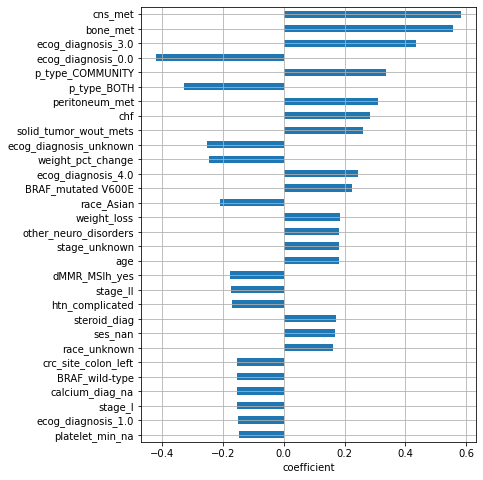

In [130]:
# Dataframe of coefficients for each variable 
coefficients_ridge = pd.DataFrame(
    ridge.named_steps['coxphsurvivalanalysis'].coef_,
    index = attributes,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes)))

non_zero = np.sum(coefficients_ridge.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_ridge.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

### 4.2 LASSO

In [131]:
lasso = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 1.0, alpha_min_ratio = 0.0001))

lasso.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [132]:
estimated_alphas = lasso.named_steps['coxnetsurvivalanalysis'].alphas_

In [133]:
estimated_alphas

array([1.62959728e-01, 1.48482835e-01, 1.35292029e-01, 1.23273058e-01,
       1.12321820e-01, 1.02343459e-01, 9.32515479e-02, 8.49673374e-02,
       7.74190733e-02, 7.05413762e-02, 6.42746748e-02, 5.85646898e-02,
       5.33619642e-02, 4.86214343e-02, 4.43020401e-02, 4.03663690e-02,
       3.67803320e-02, 3.35128687e-02, 3.05356778e-02, 2.78229723e-02,
       2.53512562e-02, 2.30991204e-02, 2.10470582e-02, 1.91772956e-02,
       1.74736375e-02, 1.59213277e-02, 1.45069208e-02, 1.32181660e-02,
       1.20439005e-02, 1.09739536e-02, 9.99905782e-03, 9.11076908e-03,
       8.30139346e-03, 7.56392055e-03, 6.89196269e-03, 6.27969972e-03,
       5.72182851e-03, 5.21351703e-03, 4.75036255e-03, 4.32835343e-03,
       3.94383444e-03, 3.59347506e-03, 3.27424064e-03, 2.98336613e-03,
       2.71833210e-03, 2.47684297e-03, 2.25680707e-03, 2.05631855e-03,
       1.87364088e-03, 1.70719178e-03, 1.55552957e-03, 1.41734061e-03,
       1.29142798e-03, 1.17670108e-03, 1.07216619e-03, 9.76917905e-04,
      

In [134]:
pipe = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 1.0, max_iter = 100000))

# 5 fold cross-validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__coxnetsurvivalanalysis__alphas': [[x] for x in estimated_alphas]}

lasso_search = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid = param_grid,
    cv = cv,
    error_score = 0.5,
    n_jobs = -1,
    refit = False)

# Run search 
warnings.filterwarnings('ignore')
lasso_search.fit(train_x_red, train_y)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=0.5,
             estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                     transformers=[('num',
                                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                                     SimpleImputer(strategy='median')),
                                                                                                                                    ('std_scaler',
                                                                                  

In [135]:
lasso_search.best_params_

{'estimator__coxnetsurvivalanalysis__alphas': [0.009110769079681409]}

In [136]:
best_lasso_alpha = lasso_search.best_params_.get('estimator__coxnetsurvivalanalysis__alphas')

In [137]:
lasso_search_results = pd.DataFrame(lasso_search.cv_results_)

In [138]:
lasso_search_results.sort_values(by = 'rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__coxnetsurvivalanalysis__alphas,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
31,0.472814,0.116466,0.044250,0.007257,[0.009110769079681409],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.718529,0.715769,0.715202,0.710694,0.699837,0.712006,0.006584,1
30,0.379158,0.049342,0.046173,0.008036,[0.009999057817642652],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.717199,0.714407,0.713689,0.709493,0.698603,0.710678,0.006522,2
29,0.328272,0.022243,0.050298,0.007025,[0.010973953610956502],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.715681,0.713101,0.711616,0.708021,0.696995,0.709083,0.006532,3
28,0.313398,0.035125,0.047237,0.007197,[0.012043900540602826],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.713732,0.711365,0.709327,0.706069,0.695040,0.707106,0.006537,4
27,0.304993,0.024428,0.049028,0.010504,[0.013218165975032753],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.711721,0.709359,0.706814,0.703672,0.693077,0.704929,0.006502,5
26,0.288291,0.021499,0.041980,0.003113,[0.014506920839680765],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.709774,0.707060,0.704022,0.701301,0.690776,0.702587,0.006556,6
25,0.294885,0.028470,0.049855,0.010869,[0.01592132771265513],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.707284,0.704430,0.701480,0.699325,0.688620,0.700228,0.006396,7
24,0.283804,0.004528,0.049720,0.008084,[0.017473637509649385],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.704294,0.702071,0.698757,0.696847,0.686447,0.697683,0.006182,8
23,0.252484,0.011756,0.046601,0.007058,[0.01917729559551336],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.701860,0.700312,0.695645,0.694433,0.684485,0.695347,0.006099,9
22,0.264455,0.021201,0.043915,0.004036,[0.021047058241571336],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.699762,0.698809,0.693848,0.692532,0.682853,0.693561,0.006030,10


In [139]:
lasso = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 1.0, 
                                                               alphas = best_lasso_alpha,
                                                               max_iter = 100000))

lasso.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [140]:
lasso_risk_scores_te = lasso.predict(test_x_red)
lasso_auc_te = cumulative_dynamic_auc(train_y, test_y, lasso_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', lasso_auc_te)

Test set AUC at 2 years: 0.7212799508602377


In [141]:
lasso_risk_scores_tr = lasso.predict(train_x_red)
lasso_auc_tr = cumulative_dynamic_auc(train_y, train_y, lasso_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', lasso_auc_tr)

Training set AUC at 2 years: 0.7130223057454665


In [142]:
# Bootstrap 10000 2-yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(lasso_risk_scores_te), len(lasso_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], lasso_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3

In [143]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.006920537614979461


In [144]:
# Bootstrap 10000 3-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(lasso_risk_scores_tr), len(lasso_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], lasso_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit

In [145]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0035233626377288068


In [146]:
crude_auc_data = {'model': 'lasso_crude',
                  'auc_2yr_te': lasso_auc_te,
                  'sem_te': standard_error_te,
                  'auc_2yr_tr': lasso_auc_tr,
                  'sem_tr': standard_error_tr}

In [147]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [148]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [149]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.768810,0.006324,0.820262,0.002853
1,rsf_crude,0.745188,0.006629,0.888791,0.002143
2,ridge_crude,0.739879,0.006750,0.736821,0.003434
3,lasso_crude,0.721280,0.006921,0.713022,0.003523


In [150]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [151]:
times = np.arange(30, 1810, 30)
crude_lasso_auc_over5 = cumulative_dynamic_auc(train_y, test_y, lasso_risk_scores_te, times)[0]

times_data = {}
values = crude_lasso_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_lasso_over5_df = pd.DataFrame(times_data, index = ['lasso_crude'])

In [152]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [153]:
crude_auc_over5 = crude_auc_over5.append(crude_lasso_over5_df, ignore_index = False)

In [154]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.856949,0.884151,0.866665,0.851224,0.844322,0.838300,0.830859,0.824993,0.820536,0.812844,...,0.742955,0.742386,0.740674,0.738619,0.737615,0.735382,0.736942,0.739815,0.737911,0.739676
rsf_crude,0.865144,0.877140,0.857458,0.836924,0.832582,0.825004,0.818601,0.811970,0.805649,0.795531,...,0.723072,0.722110,0.719606,0.718919,0.718915,0.716933,0.718147,0.722098,0.720538,0.721023
ridge_crude,0.833888,0.842563,0.830085,0.812231,0.803189,0.799863,0.794913,0.789262,0.782860,0.778468,...,0.716914,0.716532,0.714824,0.710539,0.706795,0.702304,0.703302,0.705434,0.704756,0.706410
lasso_crude,0.819796,0.839909,0.817141,0.796996,0.789548,0.783310,0.779176,0.776726,0.767813,0.760933,...,0.692981,0.692752,0.691106,0.687821,0.686137,0.682033,0.682574,0.685918,0.685633,0.684264


In [155]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [156]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes = numerical_features_red + cat_encoder + pass_through

Total number of features: 195
Number of non-zero features in final model: 37


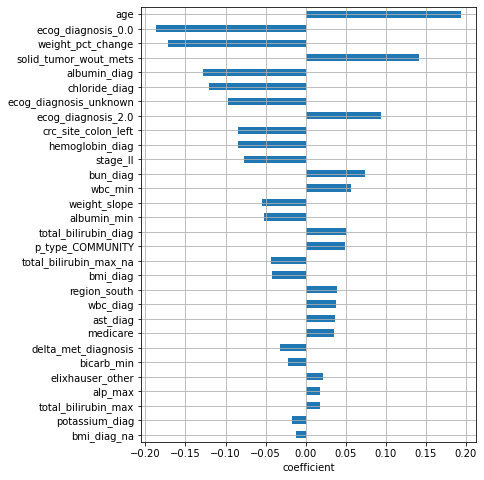

In [157]:
# Dataframe of coefficients for each variable 
coefficients_lasso = pd.DataFrame(
    lasso.named_steps['coxnetsurvivalanalysis'].coef_,
    index = attributes,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes)))

non_zero = np.sum(coefficients_lasso.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_lasso.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

### 4.3 Elastic net 

In [158]:
enet = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 0.8, alpha_min_ratio = 0.0001))

enet.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [159]:
enet.named_steps['coxnetsurvivalanalysis'].alphas_

array([2.03699660e-01, 1.85603544e-01, 1.69115037e-01, 1.54091323e-01,
       1.40402274e-01, 1.27929323e-01, 1.16564435e-01, 1.06209172e-01,
       9.67738416e-02, 8.81767202e-02, 8.03433434e-02, 7.32058622e-02,
       6.67024552e-02, 6.07767929e-02, 5.53775502e-02, 5.04579612e-02,
       4.59754150e-02, 4.18910859e-02, 3.81695972e-02, 3.47787154e-02,
       3.16890702e-02, 2.88739005e-02, 2.63088228e-02, 2.39716195e-02,
       2.18420469e-02, 1.99016596e-02, 1.81336510e-02, 1.65227075e-02,
       1.50548757e-02, 1.37174420e-02, 1.24988223e-02, 1.13884613e-02,
       1.03767418e-02, 9.45490069e-03, 8.61495337e-03, 7.84962465e-03,
       7.15228563e-03, 6.51689629e-03, 5.93795319e-03, 5.41044179e-03,
       4.92979305e-03, 4.49184383e-03, 4.09280080e-03, 3.72920766e-03,
       3.39791513e-03, 3.09605371e-03, 2.82100883e-03, 2.57039818e-03,
       2.34205109e-03, 2.13398973e-03, 1.94441196e-03, 1.77167576e-03,
       1.61428497e-03, 1.47087634e-03, 1.34020774e-03, 1.22114738e-03,
      

In [160]:
estimated_alphas = enet.named_steps['coxnetsurvivalanalysis'].alphas_

In [161]:
pipe = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 0.9, max_iter = 100000))

# 5 fold cross-validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__coxnetsurvivalanalysis__alphas': [[x] for x in estimated_alphas]}

enet_search = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid = param_grid,
    cv = cv,
    error_score = 0.5,
    n_jobs = -1,
    refit = False)

# Run search 
warnings.filterwarnings('ignore')
enet_search.fit(train_x_red, train_y)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=0.5,
             estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                     transformers=[('num',
                                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                                     SimpleImputer(strategy='median')),
                                                                                                                                    ('std_scaler',
                                                                                  

In [162]:
enet_search.best_params_

{'estimator__coxnetsurvivalanalysis__alphas': [0.010376741831217864]}

In [163]:
best_enet_alpha = enet_search.best_params_.get('estimator__coxnetsurvivalanalysis__alphas')

In [164]:
enet_search_results = pd.DataFrame(enet_search.cv_results_)

In [165]:
enet_search_results.sort_values(by = 'rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__coxnetsurvivalanalysis__alphas,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
32,0.462936,0.065083,0.053850,0.004521,[0.010376741831217864],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.718091,0.715316,0.714712,0.710266,0.699485,0.711574,0.006545,1
31,0.368296,0.040912,0.048847,0.007520,[0.01138846134960176],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.716743,0.713977,0.713106,0.709045,0.698116,0.710197,0.006525,2
30,0.342142,0.020908,0.043328,0.007754,[0.012498822272053315],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.715130,0.712585,0.710908,0.707439,0.696500,0.708513,0.006505,3
29,0.333430,0.017016,0.048965,0.008423,[0.013717442013695628],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.712928,0.710735,0.708610,0.705340,0.694425,0.706408,0.006494,4
28,0.314600,0.024855,0.039899,0.004405,[0.015054875675753534],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.711085,0.708715,0.705958,0.702907,0.692364,0.704206,0.006521,5
27,0.317564,0.012398,0.046276,0.005700,[0.01652270746879094],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.709060,0.706279,0.703168,0.700663,0.690057,0.701845,0.006540,6
26,0.321734,0.014625,0.045149,0.007731,[0.018133651049600956],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.706434,0.703692,0.700691,0.698633,0.688016,0.699493,0.006320,7
25,0.294735,0.010586,0.047668,0.009882,[0.01990165964081891],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.703416,0.701558,0.697906,0.696005,0.685732,0.696923,0.006175,8
24,0.269800,0.012836,0.049209,0.003651,[0.021842046887061733],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.701290,0.699833,0.695133,0.693923,0.683932,0.694822,0.006107,9
23,0.274421,0.016047,0.055563,0.006797,[0.0239716194943917],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.699147,0.698357,0.693365,0.691923,0.682474,0.693053,0.005976,10


In [166]:
enet = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 0.8,
                                                              alphas = [0.01138846134960176],
                                                              max_iter = 100000))

enet.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

**The second best alpha was selected since the best alpha was too small.**

In [167]:
enet_risk_scores_te = enet.predict(test_x_red)
enet_auc_te = cumulative_dynamic_auc(train_y, test_y, enet_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', enet_auc_te)

Test set AUC at 2 years: 0.7210986925281204


In [168]:
enet_risk_scores_tr = enet.predict(train_x_red)
enet_auc_tr = cumulative_dynamic_auc(train_y, train_y, enet_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', enet_auc_tr)

Training set AUC at 2 years: 0.7128095743164379


In [169]:
# Bootstrap 10000 2-yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(enet_risk_scores_te), len(enet_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], enet_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [170]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.006912243891478545


In [171]:
# Bootstrap 10000 2-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(enet_risk_scores_tr), len(enet_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], enet_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [172]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.003518285260900929


In [173]:
crude_auc_data = {'model': 'enet_crude',
                  'auc_2yr_te': enet_auc_te,
                  'sem_te': standard_error_te,
                  'auc_2yr_tr': enet_auc_tr,
                  'sem_tr': standard_error_tr}

In [174]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [175]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [176]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.768810,0.006324,0.820262,0.002853
1,rsf_crude,0.745188,0.006629,0.888791,0.002143
2,ridge_crude,0.739879,0.006750,0.736821,0.003434
3,lasso_crude,0.721280,0.006921,0.713022,0.003523
4,enet_crude,0.721099,0.006912,0.712810,0.003518


In [177]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [178]:
times = np.arange(30, 1810, 30)
crude_enet_auc_over5 = cumulative_dynamic_auc(train_y, test_y, enet_risk_scores_te, times)[0]

times_data = {}
values = crude_enet_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_enet_over5_df = pd.DataFrame(times_data, index = ['enet_crude'])

In [179]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [180]:
crude_auc_over5 = crude_auc_over5.append(crude_enet_over5_df, ignore_index = False)

In [181]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.856949,0.884151,0.866665,0.851224,0.844322,0.838300,0.830859,0.824993,0.820536,0.812844,...,0.742955,0.742386,0.740674,0.738619,0.737615,0.735382,0.736942,0.739815,0.737911,0.739676
rsf_crude,0.865144,0.877140,0.857458,0.836924,0.832582,0.825004,0.818601,0.811970,0.805649,0.795531,...,0.723072,0.722110,0.719606,0.718919,0.718915,0.716933,0.718147,0.722098,0.720538,0.721023
ridge_crude,0.833888,0.842563,0.830085,0.812231,0.803189,0.799863,0.794913,0.789262,0.782860,0.778468,...,0.716914,0.716532,0.714824,0.710539,0.706795,0.702304,0.703302,0.705434,0.704756,0.706410
lasso_crude,0.819796,0.839909,0.817141,0.796996,0.789548,0.783310,0.779176,0.776726,0.767813,0.760933,...,0.692981,0.692752,0.691106,0.687821,0.686137,0.682033,0.682574,0.685918,0.685633,0.684264
enet_crude,0.819819,0.839793,0.817031,0.796878,0.789396,0.783199,0.779032,0.776612,0.767686,0.760782,...,0.692886,0.692666,0.691042,0.687753,0.686081,0.682002,0.682528,0.685887,0.685626,0.684238


In [182]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [183]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes = numerical_features_red + cat_encoder + pass_through

Total number of features: 195
Number of non-zero features in final model: 38


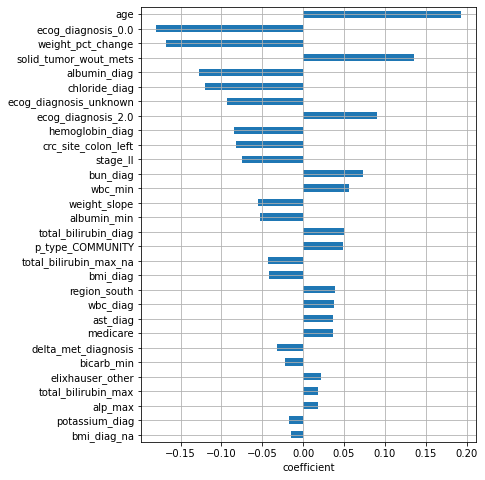

In [184]:
# Dataframe of coefficients for each variable 
coefficients_enet = pd.DataFrame(
    enet.named_steps['coxnetsurvivalanalysis'].coef_,
    index = attributes,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes)))

non_zero = np.sum(coefficients_enet.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_enet.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

**Among the penalized Cox models, the ridge penalty has the best performance in regards to test set 2 year AUC. Not surprisingly, the penalized Cox models perform worse than the gradient boosting model or the random survival forest.**

## 5. Linear survival support vector machine 

**Lastly, we'll build a survival support vector machines with a linear kernel and a ranking objective.** 

In [185]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline

from sksurv.svm import FastSurvivalSVM
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

import warnings 

import matplotlib.pyplot as plt

In [186]:
pipe = make_pipeline(preprocessor_red, FastSurvivalSVM(rank_ratio = 1, 
                                                       max_iter = 1000, 
                                                       tol = 1e-3,
                                                       random_state = 42))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__fastsurvivalsvm__alpha': 10. ** np.linspace(-3, 3, 15)}

linear_svm_search = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid = param_grid,
    cv = cv,
    error_score = 0.5,
    n_jobs = -1,
    refit = False)

# Run search 
warnings.filterwarnings('ignore')
linear_svm_search.fit(train_x_red, train_y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=0.5,
             estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                     transformers=[('num',
                                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                                     SimpleImputer(strategy='median')),
                                                                                                                                    ('std_scaler',
                                                                                  

In [187]:
linear_svm_search.best_params_

{'estimator__fastsurvivalsvm__alpha': 51.794746792312125}

In [188]:
best_linear_svm_alpha = linear_svm_search.best_params_.get('estimator__fastsurvivalsvm__alpha')

In [189]:
linear_svm_search_results = pd.DataFrame(linear_svm_search.cv_results_)

In [190]:
linear_svm_search_results.sort_values(by = 'rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__fastsurvivalsvm__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,113.925938,47.367960,0.040093,0.000745,51.794747,{'estimator__fastsurvivalsvm__alpha': 51.79474...,0.739667,0.736379,0.740068,0.732543,0.726903,0.735112,0.004917,1
4,148.434943,61.359274,0.041650,0.001233,0.051795,{'estimator__fastsurvivalsvm__alpha': 0.051794...,0.739669,0.736362,0.740062,0.732562,0.726848,0.735101,0.004932,2
12,150.597640,69.656080,0.042486,0.003316,138.949549,{'estimator__fastsurvivalsvm__alpha': 138.9495...,0.739679,0.736366,0.740044,0.732575,0.726832,0.735099,0.004934,3
9,142.912870,57.899773,0.040521,0.000827,7.196857,{'estimator__fastsurvivalsvm__alpha': 7.196856...,0.739655,0.736355,0.740044,0.732564,0.726873,0.735098,0.004917,4
3,153.039128,61.435946,0.042991,0.002530,0.019307,{'estimator__fastsurvivalsvm__alpha': 0.019306...,0.739679,0.736360,0.740073,0.732540,0.726837,0.735098,0.004942,5
14,143.218198,66.405295,0.034248,0.001515,1000.0,{'estimator__fastsurvivalsvm__alpha': 1000.0},0.739653,0.736342,0.740051,0.732574,0.726855,0.735095,0.004922,6
5,161.696539,78.856269,0.041608,0.004858,0.13895,{'estimator__fastsurvivalsvm__alpha': 0.138949...,0.739663,0.736354,0.740046,0.732566,0.726841,0.735094,0.004929,7
7,147.555484,62.818019,0.039952,0.000322,1.0,{'estimator__fastsurvivalsvm__alpha': 1.0},0.739667,0.736350,0.740045,0.732571,0.726833,0.735093,0.004932,8
10,143.201315,59.423209,0.041479,0.001067,19.306977,{'estimator__fastsurvivalsvm__alpha': 19.30697...,0.739670,0.736339,0.740045,0.732565,0.726846,0.735093,0.004928,9
6,150.203161,57.946488,0.043210,0.003370,0.372759,{'estimator__fastsurvivalsvm__alpha': 0.372759...,0.739662,0.736350,0.740042,0.732572,0.726838,0.735093,0.004929,10


In [191]:
linear_svm = make_pipeline(preprocessor_red, FastSurvivalSVM(alpha = best_linear_svm_alpha,
                                                             rank_ratio = 1,
                                                             max_iter = 1000,
                                                             tol = 1e-3,
                                                             random_state = 42))

linear_svm.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [192]:
linear_svm_risk_scores_te = linear_svm.predict(test_x_red)
linear_svm_auc_te = cumulative_dynamic_auc(train_y, test_y, linear_svm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', linear_svm_auc_te)

Test set AUC at 2 years: 0.7417011134020841


In [193]:
linear_svm_risk_scores_tr = linear_svm.predict(train_x_red)
linear_svm_auc_tr = cumulative_dynamic_auc(train_y, train_y, linear_svm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', linear_svm_auc_tr)

Training set AUC at 2 years: 0.7415031774229157


In [194]:
# Bootstrap 10000 2-yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(linear_svm_risk_scores_te), len(linear_svm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], linear_svm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [195]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.006767591672252814


In [196]:
# Bootstrap 10000 2-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(linear_svm_risk_scores_tr), len(linear_svm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], linear_svm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [197]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0034241110144291693


In [198]:
crude_auc_data = {'model': 'linear_svm_crude',
                  'auc_2yr_te': linear_svm_auc_te,
                  'sem_te': standard_error_te,
                  'auc_2yr_tr': linear_svm_auc_tr,
                  'sem_tr': standard_error_tr}

In [199]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [200]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [201]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.768810,0.006324,0.820262,0.002853
1,rsf_crude,0.745188,0.006629,0.888791,0.002143
2,ridge_crude,0.739879,0.006750,0.736821,0.003434
3,lasso_crude,0.721280,0.006921,0.713022,0.003523
4,enet_crude,0.721099,0.006912,0.712810,0.003518
5,linear_svm_crude,0.741701,0.006768,0.741503,0.003424


In [202]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [203]:
times = np.arange(30, 1810, 30)
crude_linear_svm_auc_over5 = cumulative_dynamic_auc(train_y, test_y, linear_svm_risk_scores_te, times)[0]

times_data = {}
values = crude_linear_svm_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_linear_svm_over5_df = pd.DataFrame(times_data, index = ['linear_svm_crude'])

In [204]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [205]:
crude_auc_over5 = crude_auc_over5.append(crude_linear_svm_over5_df, ignore_index = False)

In [206]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.856949,0.884151,0.866665,0.851224,0.844322,0.838300,0.830859,0.824993,0.820536,0.812844,...,0.742955,0.742386,0.740674,0.738619,0.737615,0.735382,0.736942,0.739815,0.737911,0.739676
rsf_crude,0.865144,0.877140,0.857458,0.836924,0.832582,0.825004,0.818601,0.811970,0.805649,0.795531,...,0.723072,0.722110,0.719606,0.718919,0.718915,0.716933,0.718147,0.722098,0.720538,0.721023
ridge_crude,0.833888,0.842563,0.830085,0.812231,0.803189,0.799863,0.794913,0.789262,0.782860,0.778468,...,0.716914,0.716532,0.714824,0.710539,0.706795,0.702304,0.703302,0.705434,0.704756,0.706410
lasso_crude,0.819796,0.839909,0.817141,0.796996,0.789548,0.783310,0.779176,0.776726,0.767813,0.760933,...,0.692981,0.692752,0.691106,0.687821,0.686137,0.682033,0.682574,0.685918,0.685633,0.684264
enet_crude,0.819819,0.839793,0.817031,0.796878,0.789396,0.783199,0.779032,0.776612,0.767686,0.760782,...,0.692886,0.692666,0.691042,0.687753,0.686081,0.682002,0.682528,0.685887,0.685626,0.684238
linear_svm_crude,0.843913,0.848513,0.839261,0.820474,0.810391,0.806710,0.800909,0.795907,0.790194,0.786308,...,0.708053,0.707602,0.706085,0.701936,0.698137,0.693469,0.693905,0.696134,0.695029,0.696375


In [207]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [208]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names_out(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes = numerical_features_red + cat_encoder + pass_through

Total number of features: 195
Number of non-zero features in final model: 195


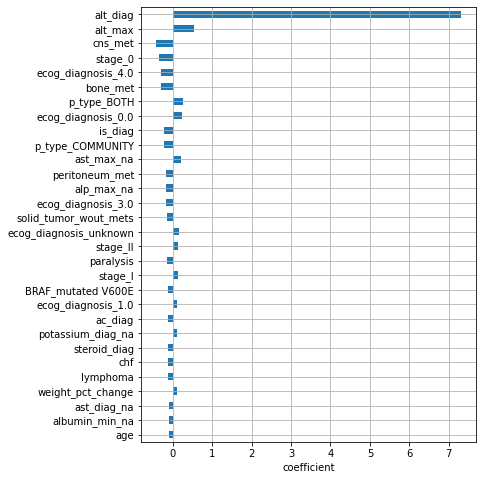

In [209]:
# Dataframe of coefficients for each variable 
coefficients_linear_svm = pd.DataFrame(
    linear_svm.named_steps['fastsurvivalsvm'].coef_,
    index = attributes,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes)))

non_zero = np.sum(coefficients_linear_svm.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_linear_svm.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

**In conclusion, the gradient boosting model has the best test set performance in regards to 2 year AUC. Random survival forest follows closely behind. The bottom performers are penalized Cox and linear survival support vector machine.** 